In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import glob
import geopandas as gpd
import contextily as cx
import xarray as xr
import seaborn as sns
from matplotlib.lines import Line2D
from causalimpact import CausalImpact

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
london = gpd.read_file('/home/dan/Downloads/ULEZ/ULEZ.shp')


In [3]:
df_site_abbrev = pd.read_csv('data/site_abbreviations.csv')
df_site_abbrev.dropna(inplace=True)
print(f'num sites: {len(df_site_abbrev)}')

df_site_locations = pd.read_csv('data/site_locations.csv')
print(f'num sites: {len(df_site_locations)}')

df_site_locations.head(10)

num sites: 133
num sites: 131


,station,classification,road_distance,height,latitude,longitude
0,Barking and Dagenham - Rush Green,Suburban,Not applicable,Not available,51.563752,0.177891
1,Barking and Dagenham - Scrattons Farm,Suburban,Not applicable,Not available,51.529389,0.132857
2,Bexley - Belvedere,Suburban,Not applicable,Not available,51.490610,0.158914
3,Bexley - Belvedere West,Urban Background,50 metres,2 metres,51.494649,0.137279
4,Bexley - Slade Green,Suburban,Not available,4 metres,51.465983,0.184877
5,Bexley - Slade Green Fidas,Suburban,Not applicable,Not available,51.465983,0.184877
6,Brent - ARK Franklin Primary Academy,Roadside,3 metres,Not available,51.532405,-0.217719
7,Brent - Ikea,Roadside,Not available,Not available,51.552476,-0.258089
8,Brent - John Keble Primary School,Roadside,Not available,Not available,51.537799,-0.247793
9,Brent - Neasden Lane,Industrial,Not applicable,Not available,51.552656,-0.248774


In [4]:
df_site_abbrev.at[70,'station'] = 'Lewisham - Laurence House Catford'
#merge df_site_abbrev and df_site_locations
df_site_locations = df_site_locations.merge(df_site_abbrev, on = 'station')


In [5]:
df_site_locations.head()

,station,classification,road_distance,height,latitude,longitude,abbreviation
0,Barking and Dagenham - Rush Green,Suburban,Not applicable,Not available,51.563752,0.177891,BG1
1,Barking and Dagenham - Scrattons Farm,Suburban,Not applicable,Not available,51.529389,0.132857,BG2
2,Bexley - Belvedere,Suburban,Not applicable,Not available,51.490610,0.158914,BX2
3,Bexley - Belvedere West,Urban Background,50 metres,2 metres,51.494649,0.137279,BQ7
4,Bexley - Slade Green,Suburban,Not available,4 metres,51.465983,0.184877,BX1


In [6]:
gdf = gpd.GeoDataFrame(df_site_locations,
                       geometry = gpd.points_from_xy(df_site_locations.longitude, df_site_locations.latitude),
                       crs="EPSG:4326")
gdf = gdf.to_crs('EPSG:3857') #switch to web mercator coordinate system

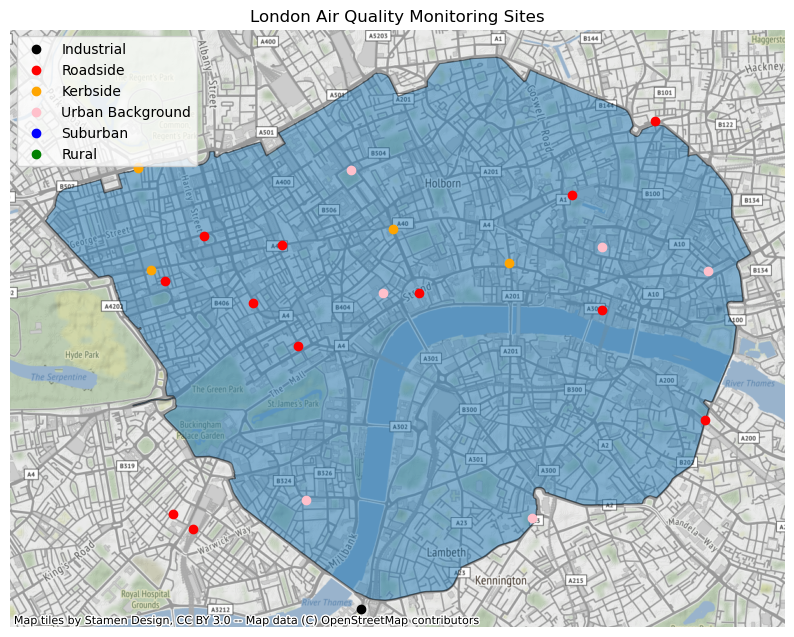

In [8]:
class_colors = {'Industrial': 'black',
                'Roadside': 'red',
                'Kerbside': 'orange',
                'Urban Background': 'pink',
                'Suburban': 'blue',
                'Rural': 'green'}

classes = class_colors.keys()

london_wm = london.to_crs(epsg = 3857) #switch to web mercator coordinate system
#london_wm.explore()
ax = london_wm.plot(figsize = (10,10), alpha = 0.5, edgecolor = 'k')
cx.add_basemap(ax)

for class_ in classes:
    gdf_class = gdf[gdf['classification'] == class_]
    gdf_class.plot(ax = ax, color = class_colors[class_], label = class_)

plt.legend()
plt.axis('off')
plt.title('London Air Quality Monitoring Sites')
plt.show()

In [9]:
sites_in_ulez = gdf[gdf['geometry'].within(london_wm.geometry.iat[0])]

/home/dan/anaconda3/envs/scrape/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


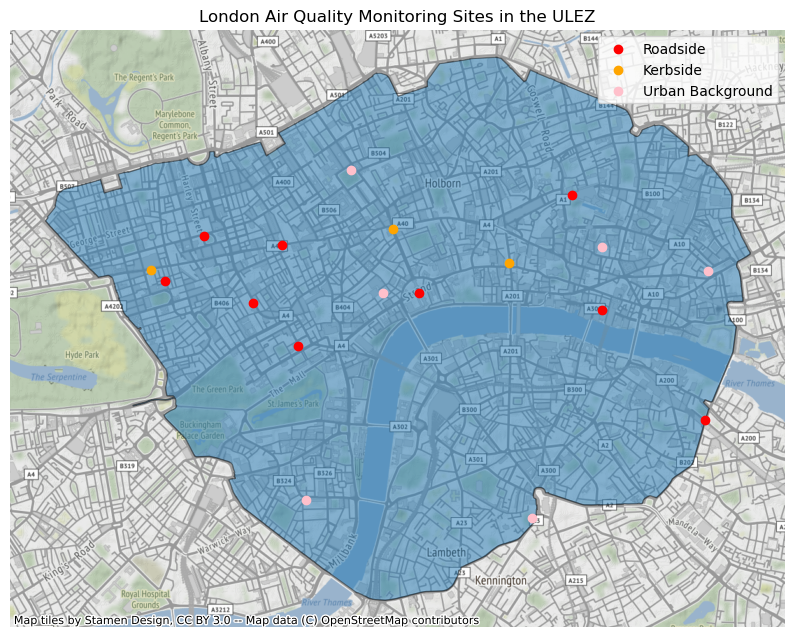

In [10]:
ax = london_wm.plot(figsize = (10,10), alpha = 0.5, edgecolor = 'k')
cx.add_basemap(ax)

for class_ in classes:
    gdf_class = sites_in_ulez[sites_in_ulez['classification'] == class_]
    gdf_class.plot(ax = ax, color = class_colors[class_], label = class_)

plt.legend()
plt.axis('off')
plt.title('London Air Quality Monitoring Sites in the ULEZ')
plt.show()

In [11]:
df = pd.read_csv('data/df_parsed_lin.csv')
df = df.drop('Unnamed: 0', axis = 1)
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
df = df.set_index('time')

In [12]:
df.head()

,BG2,BX2,BQ7,BX1,BT4,BT6,BT5,BL0,CD1,CT4,...,TH4,TH2,WA8,WA2,MY1,WM6,NB1,MW4,MW2,MW1
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01,13.4,20.3,8.000000,8.7,60.8,37.8,28.0,24.5,48.2,53.4,...,40.2,41.4,63.2,25.2,60.4,56.7,62.5,9.8,19.0,27.9
2017-01-02,32.4,44.8,23.700000,20.0,79.1,47.8,41.4,34.5,61.0,53.6,...,61.3,57.3,77.6,51.4,50.2,55.3,53.8,19.8,32.4,32.6
2017-01-03,50.3,60.1,48.400000,29.8,96.5,73.3,80.5,46.9,61.0,79.2,...,71.5,72.7,105.1,43.7,107.6,92.7,98.0,31.8,41.8,56.0
2017-01-04,42.1,51.5,42.692857,24.7,72.5,61.9,69.8,45.8,77.3,80.5,...,73.7,73.1,100.9,43.5,74.0,82.2,78.8,22.8,41.7,43.6
2017-01-05,60.6,83.8,68.000000,48.6,136.0,105.3,122.1,59.6,107.8,95.1,...,112.6,99.3,155.7,62.8,93.5,95.6,116.6,58.5,90.4,81.6


In [13]:
sites_in = list(sites_in_ulez['abbreviation'].values)

#cull list to only keep sites which have been stored in the dataframe
sites_in = [site for site in sites_in if site in df.columns]

df_in = df[sites_in]

In [23]:
sites_out = [site for site in df.columns if (site not in sites_in) and (site != 'time')]
#only keep the sites which are either suburban or rural, to keep sites far away from the city center
sites_out = [site for site in sites_out if (df_site_locations[df_site_locations['abbreviation'] == site]['classification'].values[0] in ['Rural'])]
df_out = df[sites_out]

In [24]:
sites_in

['BL0', 'CT4', 'CT3', 'SK6', 'WM6', 'NB1']

In [25]:
sites_out

['RG3']

Average over the sites to obtain a single time series for both the sites in the ULEZ and those outside the ULEZ.

In [26]:
df_in_avg = df_in.mean(axis = 1)
df_out_avg = df_out.mean(axis = 1)

df_in_avg.name = 'in'
df_out_avg.name = 'out'

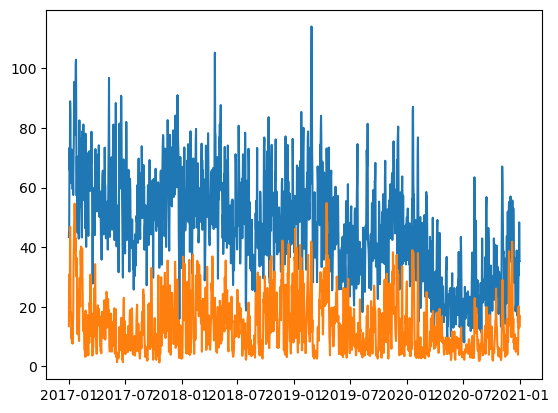

In [27]:
plt.plot(df_in_avg)
plt.plot(df_out_avg)

In [28]:
df_tot = pd.merge(df_in_avg, df_out_avg, left_index = True, right_index = True)
df_tot.index = pd.to_datetime(df.index, format='%Y-%m-%d')

In [29]:
ts_pre_period = [pd.to_datetime(date, format='%Y-%m-%d') for date in ["2017-01-01", "2019-04-07"]]
ts_post_period = [pd.to_datetime(date, format='%Y-%m-%d') for date in ["2019-04-08", "2020-02-01"]]

In [30]:
ts_impact = CausalImpact(df_tot, ts_pre_period, ts_post_period, model_args={"nseasons":7})
ts_impact.run()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30161D+00    |proj g|=  3.27441D-01

At iterate    5    f=  1.25434D+00    |proj g|=  1.68794D-02

At iterate   10    f=  1.25311D+00    |proj g|=  5.02567D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   5.026D-06   1.253D+00
  F =   1.2531057338300096     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


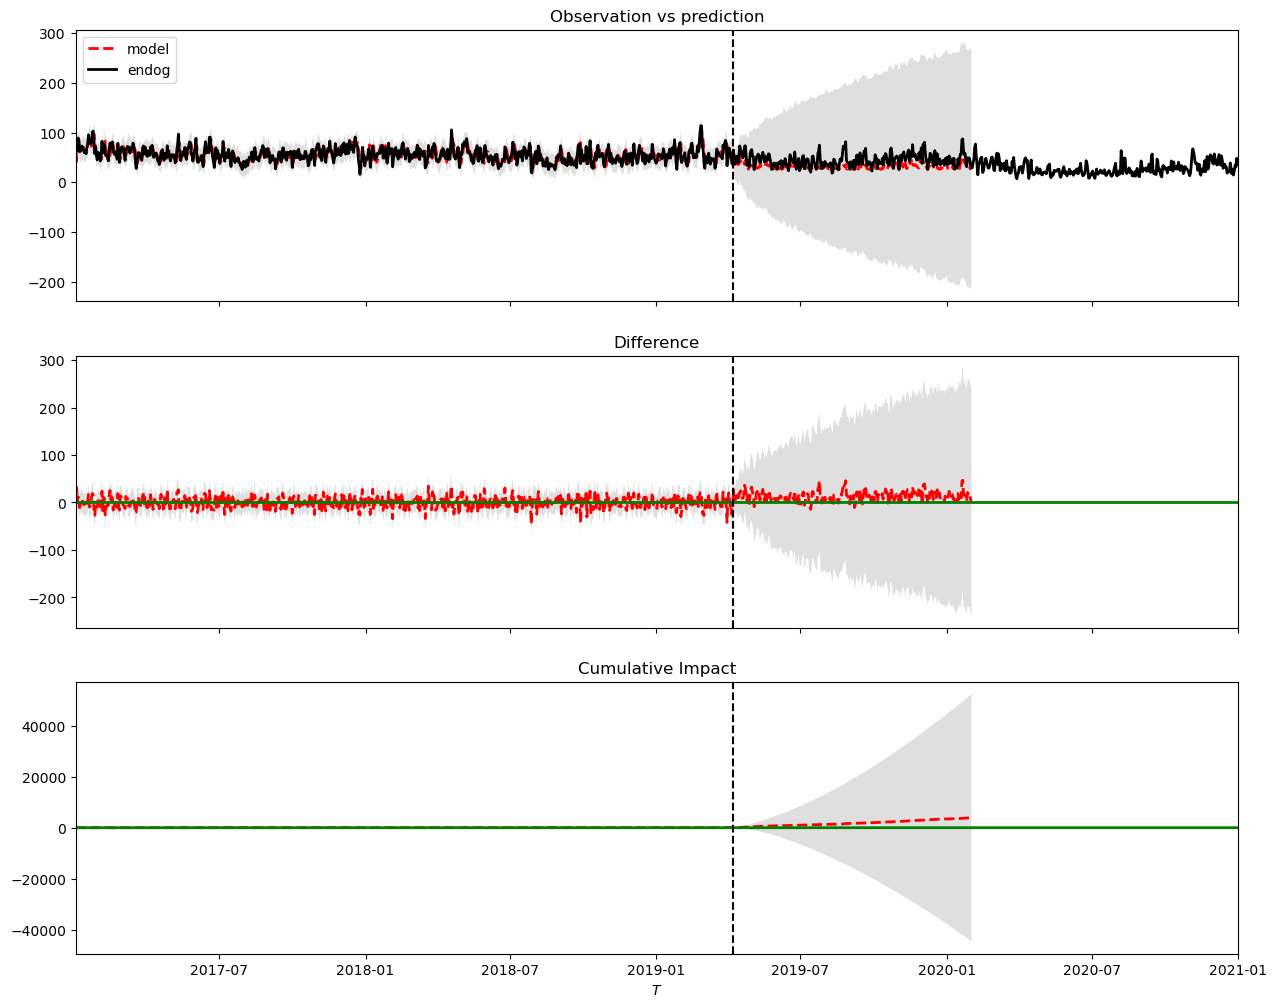

In [31]:
ts_impact.plot()

From the above analysis, it seems that the ULEZ has not had a significant impact on the air quality in the city center. However, our analysis assumes that site monitors which are outside of the ULEZ are not impacted by the formation of the ULEZ, and therefore we can use these out-of-ULEZ monitors as controls.

This assumption may not be correct-- if people driving in the ULEZ have to pay a fee for their high-emission cars, they may not drive at all, preferring to take a bus or subway. This would impact the traffic outside of the ULEZ as well. We can attempt to control for this by using sites far away from the city center, where people probably never travel to the city center. Doing so leads to us assuming that these sites are still similar in nature (i.e. are strongly correlated)  to the behavior of the sites deep in the city center (i.e. in the ULEZ.)

Moreover, there is an important caveat: our analysis uses data which has been imputed. Recall that our imputation procedure replaces missing values with the average NO2 concentration from similar sites. This average is over all sites of the same class (e.g. roadside.) 

However, since the only difference between the control and impacted sites in our analysis is the geographic location, we should be careful to perform imputation by only averaging over nearest-neighbor sites of the same type.